type of node2: hinge
total # nodes: 6


'length of m2 is exactly'

sqrt((3 - pi/2)**2 + (-3 - pi/2)**2)

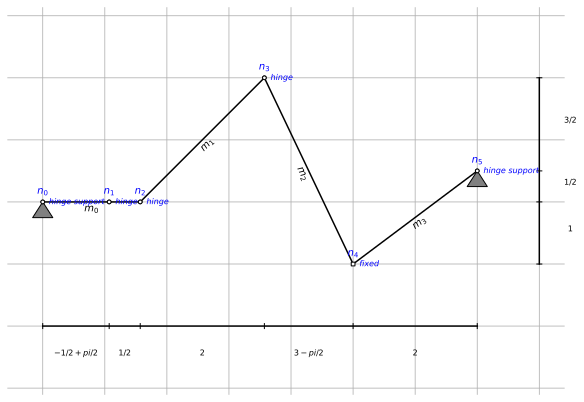

hinge_support


In [18]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

%config InlineBackend.figure_formats = ['svg']


class Member:
    def __init__(self, x1, y1, x2, y2, E, I, A, member_id):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.E = E
        self.I = I
        self.A = A
        self.length = sp.sqrt((x2 - x1) ** 2 + (y2 - x1) ** 2)
        self.angle = sp.atan2(y2 - y1, x2 - x1)
        self.angle_deg = sp.deg(self.angle)
        self.member_id = member_id


class Node:
    def __init__(self, x, y, node_type, node_id):
        self.x = x
        self.y = y
        self.node_type = node_type
        self.node_id = node_id


class Support:
    def __init__(self, x, y, support_type, global_angle, support_id):
        self.x = x
        self.y = y
        self.support_type = support_type
        self.global_angle = global_angle
        self.support_id = support_id


##################################################################################


class Structure2D:
    def __init__(self):
        self.members = []
        self.supports = []
        self.nodes = []

    ######################### MEMBER FUNCTIONS ########################################
    def add_member_length_angle(self, start_x, start_y, length, angle, E=1, I=1, A=1):
        angle = angle / 180 * sp.pi
        x1 = start_x
        y1 = start_y
        x2 = x1 + length * sp.cos(angle)
        y2 = y1 + length * sp.sin(angle)
        return self.add_member_coordinates(x1, y1, x2, y2, E, I, A)

    def add_member_coordinates(self, x1, y1, x2, y2, E=1, I=1, A=1):
        member_id = len(self.members)
        member = Member(x1, y1, x2, y2, E, I, A, member_id)
        self.members.append(member)

        # check start node
        self.add_or_update_node(x1, y1, "fixed", overwrite=False)
        # check end node
        self.add_or_update_node(x2, y2, "fixed", overwrite=False)
        return member

    ######################### NODE FUNCTIONS ########################################
    # check if the node already exists or update type
    def add_or_update_node(self, x, y, new_node_type, overwrite=True):
       

        for node in self.nodes:
            if node.x == x and node.y == y:
                if overwrite:
                    #check id overwite is active (members never overwrite existing nodes)
                    node.node_type = new_node_type
                return node

        # add a new node if it does not exist
        node_id = len(self.nodes)
        new_node = Node(x, y, new_node_type, node_id)
        self.nodes.append(new_node)
        return new_node

    ########################### SUPPORT FUNCTIONS ########################################
    def add_support(self, x, y, support_type="pin", global_angle=0):
        global_angle = np.deg2rad(global_angle)
        support_id = len(self.supports)
        support = Support(
            x,
            y,
            support_type=support_type,
            global_angle=global_angle,
            support_id=support_id,
        )
        self.supports.append(support)

        # determine the new node type based on the support type
        ### NEED MORE STUFF ADDED HERE
        if support_type == "pin":
            new_node_type = "hinge_support"
        elif support_type == "fixed":
            new_node_type = "fixed_support"
        else:
            pass

        
        self.add_or_update_node(x, y, new_node_type, overwrite=True)

        return support

    ########################### HINGE FUNCTIONS ########################################
    def add_hinge(self, x, y):
        node_id = len(self.nodes)
        hinge = Node(x, y, "hinge", node_id)

        # Update node
        self.add_or_update_node(x, y, "hinge", overwrite=True)
        return hinge

    # %%%%%%%%%%%%%%%%%%%%%%%%% PLOTTING FUNCTIONS %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    def plot(
        self,
        show_member_labels=False,
        show_properties=False,
        show_forces=True,
        draw_size=1,
        show_axis=False,
        draw_all_nodes=False,
        show_node_labels=False,
        show_node_labels_types=False,
        show_length_bars=True,
        length_bar_exact_values=True,
    ):
        ############## length side bars ############################
        def get_length_ticks():
            x_values_for_length_lines = []
            y_values_for_length_lines = []

            for node in self.nodes:
                x_values_for_length_lines.append(node.x)
                y_values_for_length_lines.append(node.y)

            simplified_x = [sp.nsimplify(expr) for expr in x_values_for_length_lines]
            simplified_y = [sp.nsimplify(expr) for expr in y_values_for_length_lines]

            unique_x = list(dict.fromkeys(simplified_x))
            unique_y = list(dict.fromkeys(simplified_y))

            x_length_ticks = sorted(unique_x)
            y_length_ticks = sorted(unique_y)

            return x_length_ticks, y_length_ticks

        # Draw nodes
        def draw_nodes(ax, x, y, node_type, size, edgecolor="black", facecolor="black"):
            if node_type == "hinge" or node_type == "hinge_support":
                size = size * 1 / 50
                circle = patches.Circle(
                    (x, y), size, edgecolor=edgecolor, facecolor="white"
                )
                ax.add_patch(circle).zorder = 11
            elif node_type == "fixed" or node_type == "fixed_support":
                size = size * 1 / 25
                rectangle = patches.Rectangle(
                    (x - size / 2, y - size / 2),
                    size,
                    size,
                    edgecolor=edgecolor,
                    facecolor="white",
                )
                ax.add_patch(rectangle).zorder = 11

        # Draw supports
        def draw_support_pin(
            ax, x, y, global_angle, size, edgecolor="black", facecolor="grey"
        ):
            size = size * 1 / 5

            triangle = np.array(
                [
                    [x, y],
                    [x - np.cos(1) * size, y - np.sin(1) * size],
                    [x + np.cos(1) * size, y - np.sin(1) * size],
                ]
            )

            rotation_matrix = np.array(
                [
                    [np.cos(global_angle), -np.sin(global_angle)],
                    [np.sin(global_angle), np.cos(global_angle)],
                ]
            )

            triangle = np.dot(
                triangle - np.array([x, y]), rotation_matrix.T
            ) + np.array([x, y])

            triangle_patch = patches.Polygon(
                triangle, closed=True, edgecolor=edgecolor, facecolor=facecolor
            )

            circle = patches.Circle(
                (x, y), size * 0.1, edgecolor=edgecolor, facecolor="white"
            )

            ax.add_patch(triangle_patch).zorder = 10
            ax.add_patch(circle).zorder = 10

        # Plot members
        x_len_ticks = get_length_ticks()[0]
        # y_len_ticks = get_length_ticks()[1]

        offset = float(sum(x_len_ticks)) / 10

        for member in self.members:
            x = [float(member.x1), float(member.x2)]
            y = [float(member.y1), float(member.y2)]
            angle = float(member.angle)
            E = member.E
            I = member.I
            A = member.A
            member_id = member.member_id

            plt.plot(x, y, "k-")

            mid_x = (x[0] + x[1]) / 2
            mid_y = (y[0] + y[1]) / 2

            if show_member_labels:
                if (
                    angle > np.pi / 2
                    and angle < 3 * np.pi / 2
                    or angle < -np.pi / 2
                    and angle > -3 * np.pi / 2
                ):
                    angle = angle + np.pi

                plt.text(
                    mid_x + (offset**2 * 0.032 * np.sin(angle)),
                    mid_y - (offset**2 * 0.032 * np.cos(angle)),
                    f"$m_{member_id}$",
                    ha="center",
                    va="center",
                    rotation=angle * 180 / np.pi,
                )

            if show_properties:
                plt.text(
                    mid_x + 0.2 * np.sin(angle),
                    mid_y - 0.2 * np.cos(angle),
                    f"$EI={E*I}, EA={E*A}$",
                    ha="center",
                    va="center",
                    rotation=angle * 180 / np.pi,
                )

        # plot supports
        for support in self.supports:
            x = float(support.x)
            y = float(support.y)
            support_type = support.support_type
            global_angle = float(support.global_angle)

            ### MORE TYPES NEED TO BE ADDED
            if support_type == "pin":
                draw_support_pin(
                    plt.gca(), x, y, global_angle=global_angle, size=draw_size
                )
            else:
                pass

        # Plot nodes

        for node in self.nodes:
            x = float(node.x)
            y = float(node.y)
            node_type = node.node_type

            if node_type == "hinge" or node_type == "support_hinge":
                draw_nodes(
                    plt.gca(), x, y, node_type, size=draw_size, edgecolor="black"
                )

            if draw_all_nodes:
                draw_nodes(
                    plt.gca(), x, y, node_type, size=draw_size, edgecolor="black"
                )

            if show_node_labels:
                plt.text(
                    x,
                    y + 0.1,
                    f"$n_{node.node_id}$",
                    ha="center",
                    va="bottom",
                    color="blue",
                    zorder=12,
                )

            if show_node_labels_types:
                node_type_text = node_type.replace("_", r"\ ")
                plt.text(
                    x + 0.1,
                    y,
                    f"${node_type_text}$",
                    ha="left",
                    va="center",
                    color="blue",
                    fontsize=8,
                    zorder=12,
                )

            # if show_all_nodes:
            #     draw_nodes(plt.gca(), x, y, node_type, size=2, edgecolor="black")

        if show_length_bars:
            x_length_ticks, y_length_ticks = get_length_ticks()
            x_min = round(float(y_length_ticks[0]) - 1, 0)
            y_min = round(float(x_length_ticks[-1]) + 1, 0)

            # length lines plot
            plt.plot(
                x_length_ticks, x_min * np.ones(len(x_length_ticks)), "k", marker="|"
            )
            plt.plot(
                y_min * np.ones(len(y_length_ticks)), y_length_ticks, "k", marker="_"
            )

            # lenth per segment text
            for i in range(0, len(x_length_ticks) - 1):
                loc = (x_length_ticks[i] + x_length_ticks[i + 1]) / 2
                segment_lenth = sp.Abs(
                    sp.simplify(x_length_ticks[i + 1] - x_length_ticks[i])
                )
                if length_bar_exact_values:
                    # print(float(loc) - y_length_ticks[0])
                    plt.text(
                        float(loc),
                        x_min - 0.5,
                        f"${segment_lenth}$",
                        ha="center",
                        va="bottom",
                        color="black",
                        fontsize=8,
                    )
                else:
                    plt.text(
                        float(loc),
                        x_min - 0.5,
                        f"${round(float(segment_lenth),2)}$",
                        ha="center",
                        va="bottom",
                        color="black",
                        fontsize=8,
                    )

            for i in range(0, len(y_length_ticks) - 1):
                loc = (y_length_ticks[i] + y_length_ticks[i + 1]) / 2
                segment_lenth = sp.Abs(
                    sp.simplify(y_length_ticks[i + 1] - y_length_ticks[i])
                )
                if length_bar_exact_values:
                    plt.text(
                        y_min + 0.5,
                        float(loc),
                        f"${segment_lenth}$",
                        ha="center",
                        va="bottom",
                        color="black",
                        fontsize=8,
                    )
                else:
                    plt.text(
                        y_min + 0.5,
                        float(loc),
                        f"${round(float(segment_lenth),2)}$",
                        ha="center",
                        va="bottom",
                        color="black",
                        fontsize=8,
                    )

        #### PLOT STYLE ####
        if not show_axis:
            plt.tick_params(
                axis="both",
                which="both",
                bottom=False,
                top=False,
                labelbottom=False,
                right=False,
                left=False,
                labelleft=False,
            )

        ax = plt.gca()
        ax.set_aspect("equal", adjustable="datalim")

        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        plt.grid()

        plt.show()


##########################################################################################################################################################

s = Structure2D()

# add support x, y, type="pin"
s.add_support(0, 0, "pin")

# everything supports sympy expressions for examplr sp.pi/2
# add hinge x, y
s.add_hinge(sp.pi / 2 - 0.5, 0)

# add_member_coordinates(x1, y1, x2, y2, E=1, I=1, A=1)
s.add_member_coordinates(s.supports[0].x, s.supports[0].y, sp.pi / 2, 0)

# add_member_lenth_angle(start_x, start_y, length, angle, E=1, I=1, A=1)
s.add_member_length_angle(s.members[0].x2, 0, sp.sqrt(2) * 2, 45)


# add_member_coordinates(x1, y1, x2, y2, E=1, I=1, A=1)
s.add_member_coordinates(s.members[1].x2, s.members[1].y2, 5, -1)
s.add_member_coordinates(s.members[2].x2, s.members[2].y2, 7, 0.5)

# add_support(x, y, support_type='pin', global_angle=0)
s.add_support(s.nodes[5].x, s.nodes[5].y, "pin")

# add hinge x, y (this will overwrite the fixed node into a hinge)
s.add_hinge(s.nodes[2].x, s.nodes[2].y)

# this one is inored
s.add_hinge(s.members[1].x1, 0)

print(f"type of node{s.nodes[2].node_id}: {s.nodes[2].node_type}")
print(f"total # nodes: {len(s.nodes)}")

s.add_hinge(s.nodes[3].x, s.nodes[3].y)

display("length of m2 is exactly", s.members[2].length)

##### plot the structure ####
plt.figure(figsize=(10, 7))
s.plot(
    draw_size=1.5,
    show_axis=False,
    show_member_labels=True,
    draw_all_nodes=True,
    show_node_labels=True,
    show_node_labels_types=True,
    show_length_bars=True,
    length_bar_exact_values=True,
)
print(s.nodes[0].node_type)

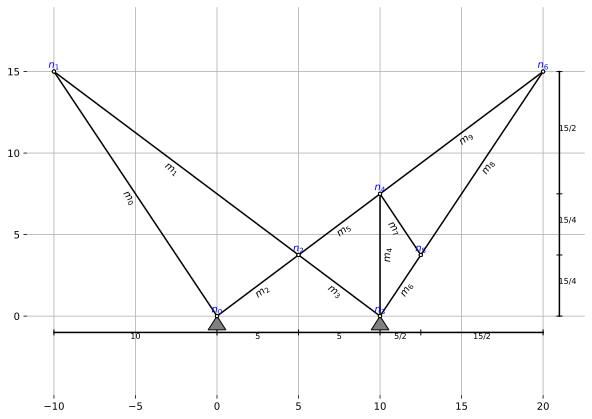

0.643501108793284 - pi


In [22]:
s = Structure2D()


s.add_support(0, 0)

s.add_member_coordinates(s.supports[0].x, s.supports[0].y, -10, 15)
s.add_member_coordinates(s.members[0].x2, s.members[0].y2, 5, 3.75)
s.add_member_coordinates(
    s.supports[0].x, s.supports[0].y, s.members[1].x2, s.members[1].y2
)

s.add_support(10, 0, "pin")
s.add_member_coordinates(s.supports[1].x, s.supports[1].y, s.nodes[2].x, s.nodes[2].y)
s.add_member_coordinates(s.supports[1].x, s.supports[1].y, s.supports[1].x, 7.5)
s.add_member_coordinates(s.nodes[4].x, s.nodes[4].y, s.nodes[2].x, s.nodes[2].y)
s.add_member_coordinates(s.supports[1].x, s.supports[1].y, 12.5, 3.75)
s.add_member_coordinates(s.nodes[5].x, s.nodes[5].y, s.nodes[4].x, s.nodes[4].y)
s.add_member_coordinates(s.nodes[5].x, s.nodes[5].y, 20, 15)
s.add_member_coordinates(s.nodes[6].x, s.nodes[6].y, s.nodes[4].x, s.nodes[4].y)

s.add_hinge(s.nodes[1].x, s.nodes[1].y)
s.add_hinge(s.nodes[2].x, s.nodes[2].y)
s.add_hinge(s.nodes[4].x, s.nodes[4].y)
s.add_hinge(s.nodes[5].x, s.nodes[5].y)
s.add_hinge(s.nodes[6].x, s.nodes[6].y)

# build add node type
# fix grid spacing
# fix lenth bars distance and text distance


##### plot the structure ####
plt.figure(figsize=(10, 7))
s.plot(
    draw_size=5,
    show_axis=True,
    show_member_labels=True,
    draw_all_nodes=True,
    show_node_labels=True,
    show_node_labels_types=False,
    show_length_bars=True,
    length_bar_exact_values=True,
)

print(s.members[9].angle)